# Nick's Star.

In [32]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tess_stars2px import tess_stars2px_function_entry
import tess_rotation as tr
import eleanor
import lightkurve as lk
import starspot as ss
from astropy.io import fits

from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [2]:
ticid = 176956893

Create a CPM light curve: download TESS cuts.

In [3]:
with suppress_stdout():
    tr.download_tess_cuts(ticid, lower_sector_limit=0, upper_sector_limit=26, tesscut_path="/Users/rangus/projects/TESS-rotation/data/TESScut")

Select an aperture in each sector.

In [4]:
with suppress_stdout():
    star = tr.Star(ticid, "/Users/rangus/projects/TESS-rotation/data/TESScut", upper_sector_limit=26)

In [5]:
with suppress_stdout():
    plt.figure(figsize=(8, 8))
    collims1, rowlims1, fig = tr.select_aperture(1, [32, 36], [32, 36], star.fits_file_names[0], plot=False)

<Figure size 576x576 with 0 Axes>

In [6]:
with suppress_stdout():
    plt.figure(figsize=(8, 8))
    collims2, rowlims2, fig = tr.select_aperture(2, [32, 35], [32, 36], star.fits_file_names[1], plot=False)

<Figure size 576x576 with 0 Axes>

In [7]:
with suppress_stdout():
    plt.figure(figsize=(8, 8))
    collims3, rowlims3, fig = tr.select_aperture(3, [32, 36], [32, 36], star.fits_file_names[2], plot=False)

<Figure size 576x576 with 0 Axes>

In [8]:
with suppress_stdout():
    plt.figure(figsize=(8, 8))
    collims4, rowlims4, fig = tr.select_aperture(4, [32, 36], [32, 35], star.fits_file_names[3], plot=False)

<Figure size 576x576 with 0 Axes>

In [9]:
with suppress_stdout():
    plt.figure(figsize=(8, 8))
    collims5, rowlims5, fig = tr.select_aperture(5, [32, 36], [32, 35], star.fits_file_names[4], plot=False)

<Figure size 576x576 with 0 Axes>

In [10]:
with suppress_stdout():
    plt.figure(figsize=(8, 8))
    collims6, rowlims6, fig = tr.select_aperture(6, [32, 36], [32, 35], star.fits_file_names[5], plot=False)

<Figure size 576x576 with 0 Axes>

In [11]:
with suppress_stdout():
    plt.figure(figsize=(8, 8))
    collims7, rowlims7, fig = tr.select_aperture(7, [32, 36], [32, 36], star.fits_file_names[6], plot=False)

<Figure size 576x576 with 0 Axes>

In [12]:
with suppress_stdout():
    plt.figure(figsize=(8, 8))
    collims8, rowlims8, fig = tr.select_aperture(8, [32, 36], [32, 36], star.fits_file_names[7], plot=False)

<Figure size 576x576 with 0 Axes>

In [13]:
with suppress_stdout():
    plt.figure(figsize=(8, 8))
    collims9, rowlims9, fig = tr.select_aperture(9, [32, 36], [32, 36], star.fits_file_names[8], plot=False)

<Figure size 576x576 with 0 Axes>

In [14]:
with suppress_stdout():
    plt.figure(figsize=(8, 8));
    collims10, rowlims10, fig = tr.select_aperture(10, [32, 36], [32, 35], star.fits_file_names[9], plot=False)

<Figure size 576x576 with 0 Axes>

In [15]:
with suppress_stdout():
    plt.figure(figsize=(8, 8))
    collims11, rowlims11, fig = tr.select_aperture(11, [32, 36], [32, 36], star.fits_file_names[10], plot=False)

<Figure size 576x576 with 0 Axes>

In [16]:
colpixlist = [collims1, collims2, collims3, collims4, collims5, collims6, collims7, collims8, collims9, collims10, collims11]
rowpixlist = [rowlims1, rowlims2, rowlims3, rowlims4, rowlims5, rowlims6, rowlims7, rowlims8, rowlims9, rowlims10, rowlims11]

Get CPM light curve.

In [17]:
with suppress_stdout():
    star.CPM_recover(colpixlist, rowpixlist)

Stitch together with a GP.

In [18]:
time, flux, flux_err = star.stitch_light_curve()

Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]


message: Optimization terminated successfully.
logp: 510.74729325570644 -> 3400.011545156047


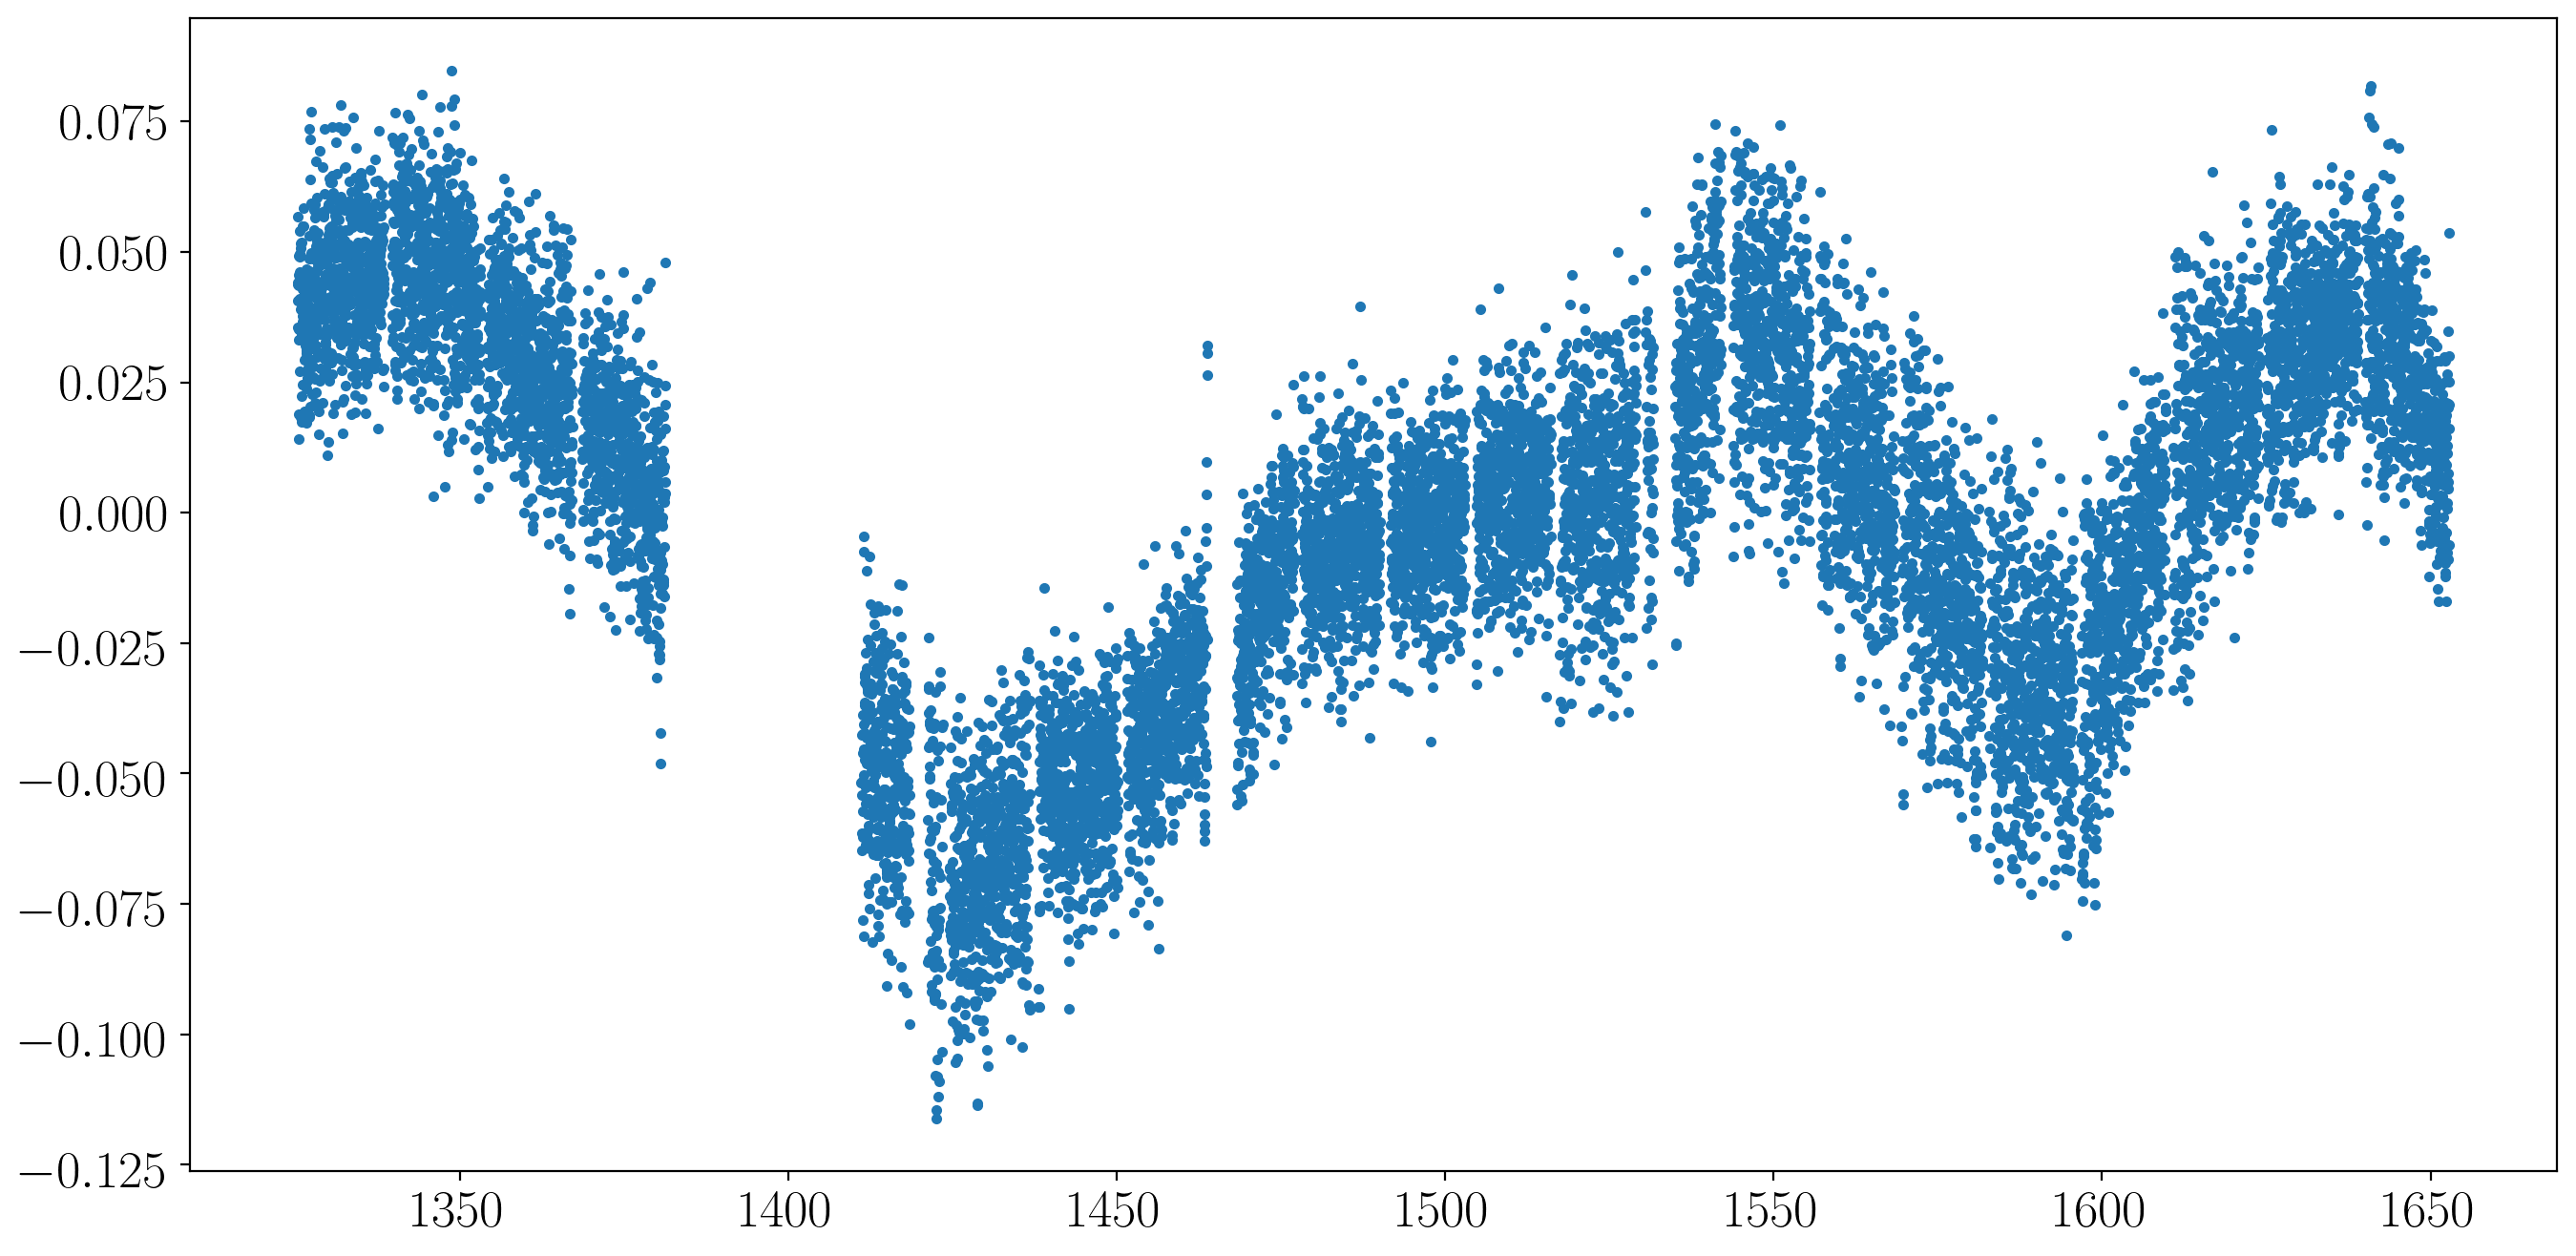

In [19]:
plt.figure(figsize=(16, 8), dpi=200)
p = np.polyfit(time, flux, 1)
plt.plot(time, flux - np.polyval(p, time), ".")

In [20]:
m = np.isfinite(time) & np.isfinite(flux)
rotate = ss.RotationModel(time[m], flux[m]-np.polyval(p, time[m]), flux_err[m])

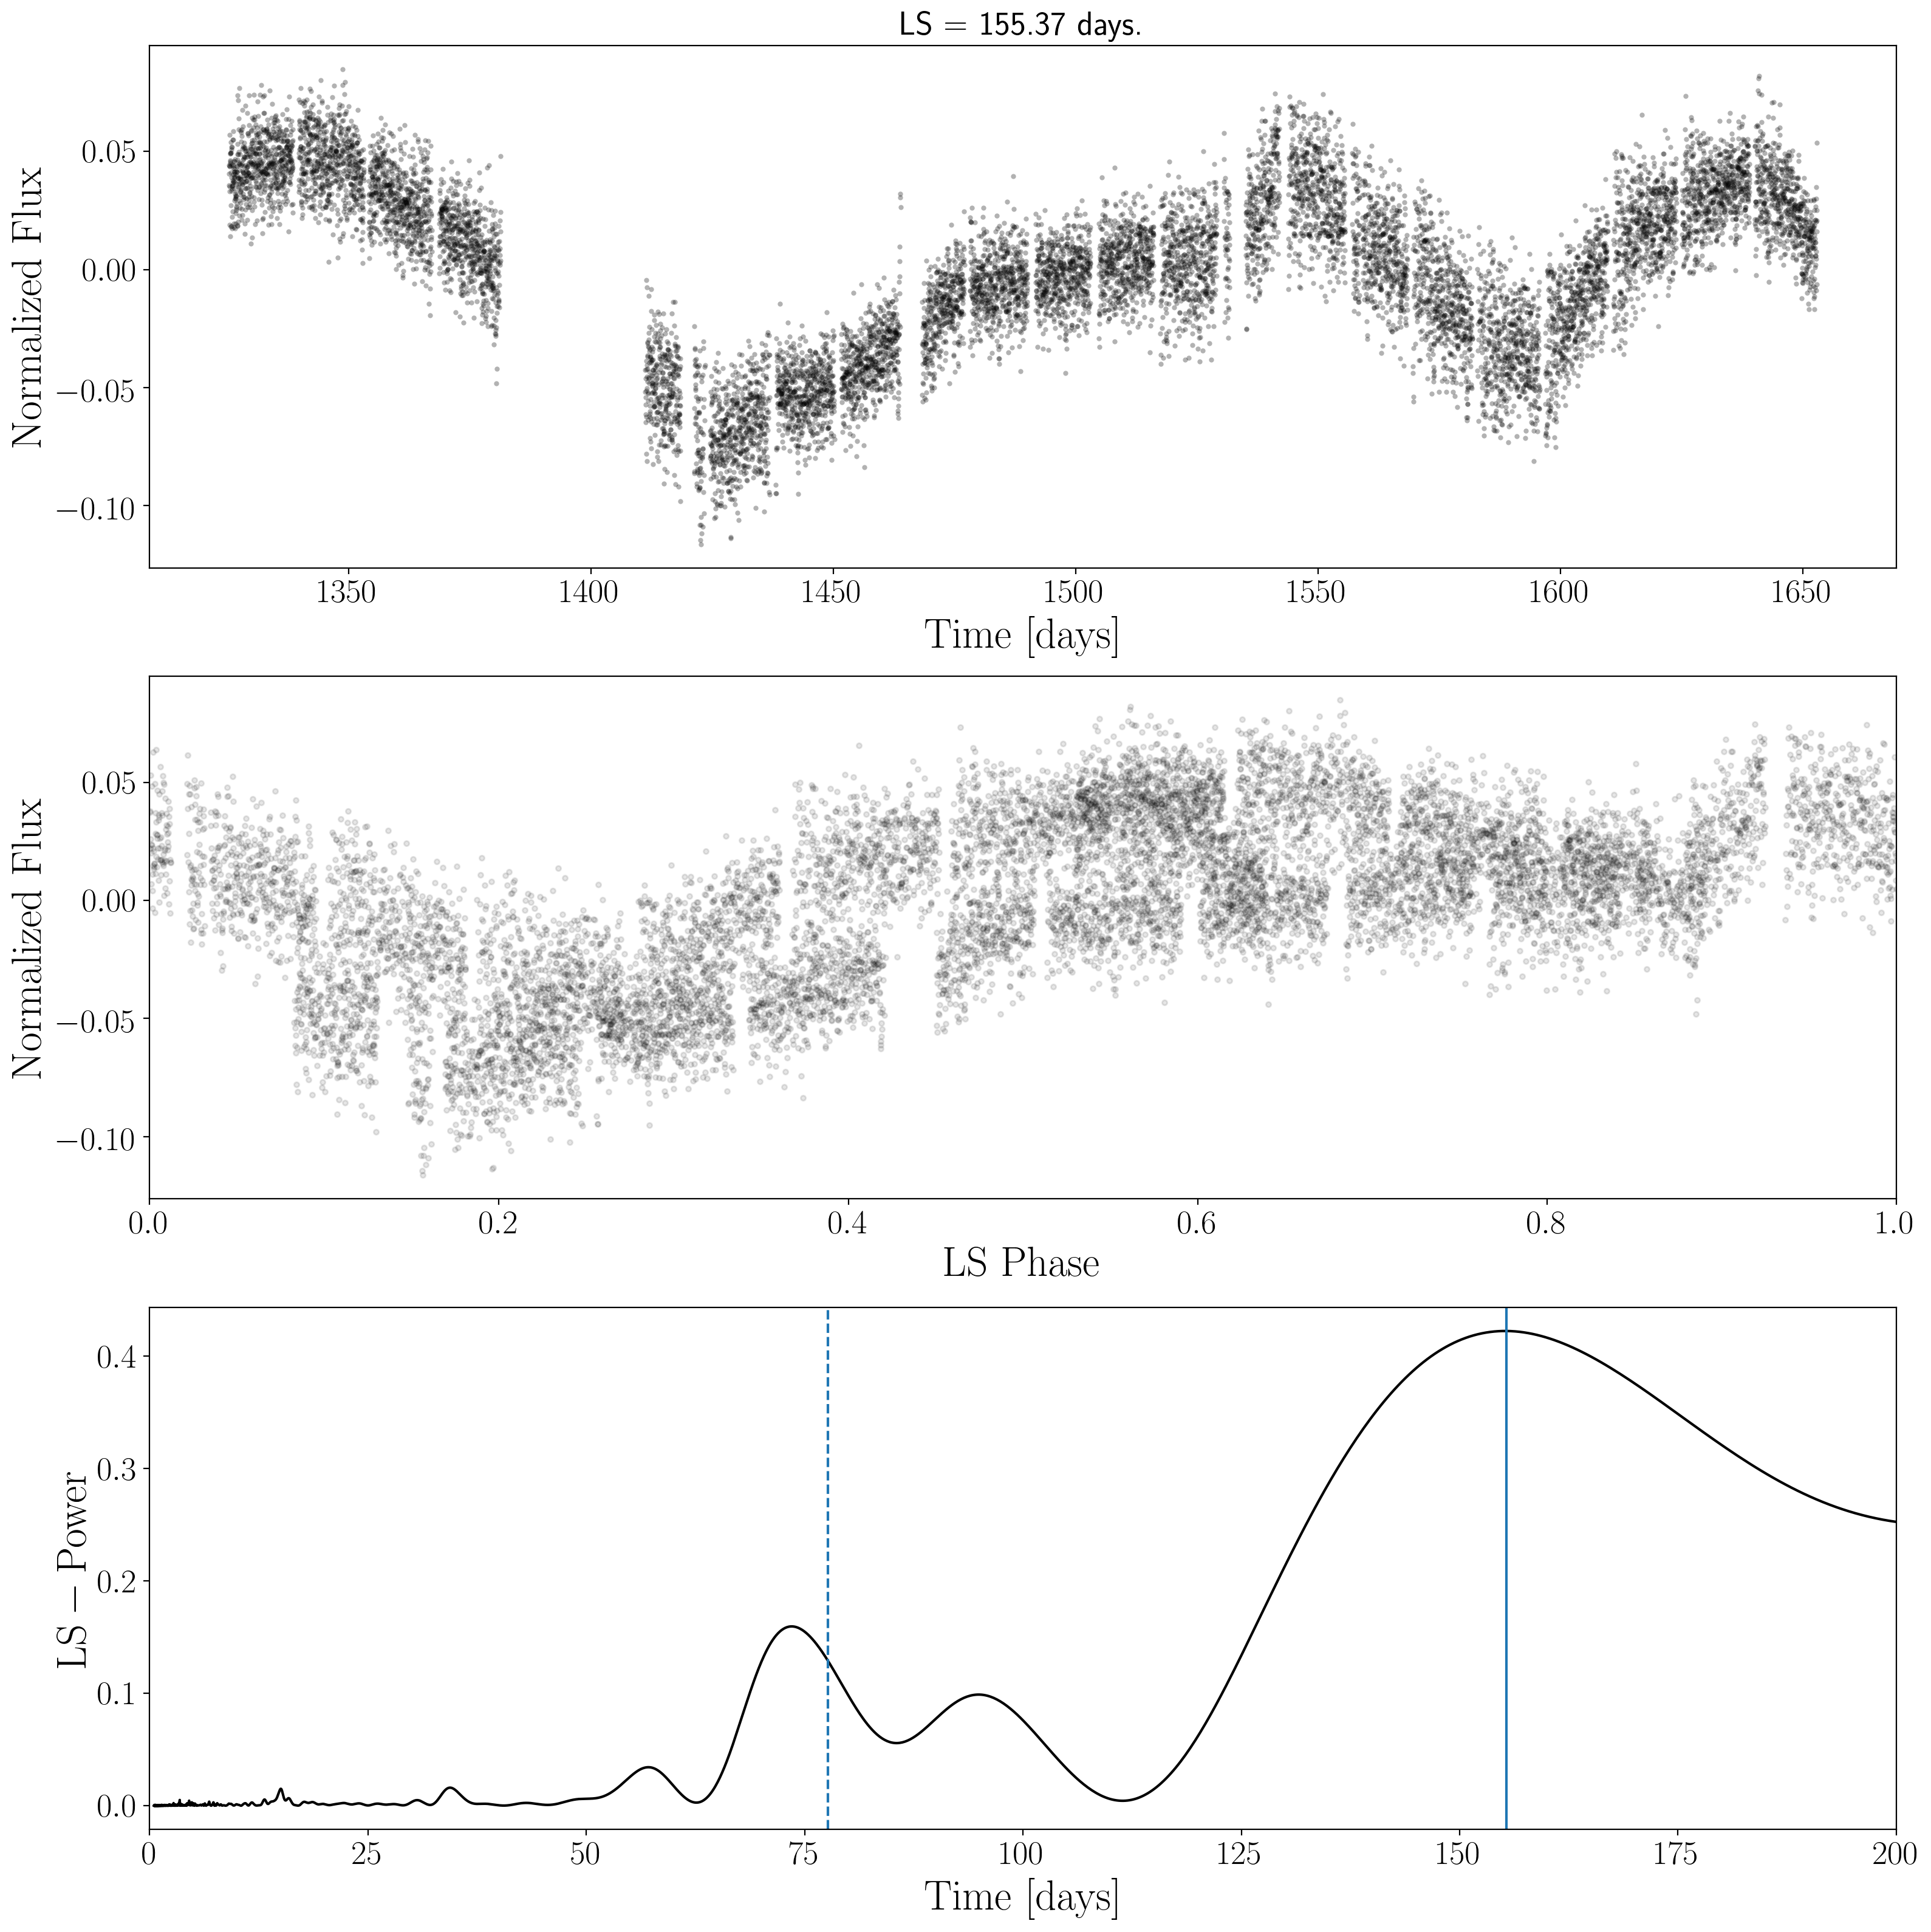

In [21]:
ls_period = rotate.ls_rotation(max_period = 200)
# acf_period = rotate.acf_rotation(interval="TESS")
fig = rotate.big_plot(methods=["ls"], method_xlim=(0, 200))

In [22]:
# rotate.gp_rotation(tune=1000, draws=1000)

In [23]:
# rotate.plot_prediction()

In [24]:
# rotate.plot_posterior()

In [25]:
x, y, yerr = time[m], flux[m]-np.polyval(p, time[m]), flux_err[m]
x, y, yerr = x[::10], y[::10], yerr[::10]

sort = np.argsort(x)
y = np.ascontiguousarray(y[sort], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[sort], dtype=np.float64)
x = np.ascontiguousarray(x[sort], dtype=np.float64)

<ErrorbarContainer object of 3 artists>

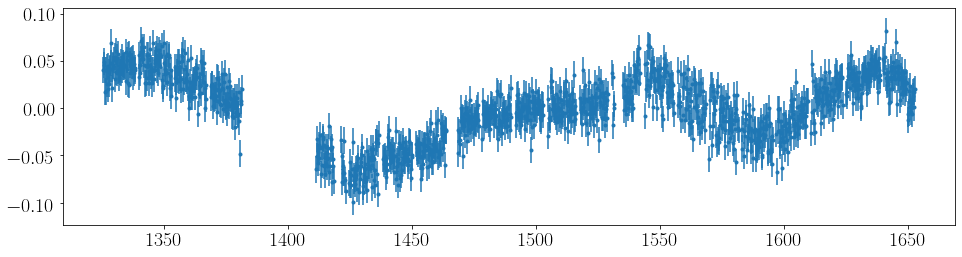

In [26]:
plt.figure(figsize=(16, 4))
plt.errorbar(x, y, yerr=yerr, fmt=".")

In [27]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
print(peak)
init = peak["period"]

{'index': 60, 'log_power': -9.368807096356207, 'period': 73.38678130640369, 'period_uncert': 5.633841727113703}


In [30]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(yerr)), sd=2.0)

    # A term to describe the non-periodic variability
    logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y)), sd=5.0)
    logw0 = pm.Normal("logw0", mu=np.log(2 * np.pi / 10), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(200))
    logperiod = BoundedNormal("logperiod", mu=np.log(init), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = xo.distributions.UnitUniform("mix")

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
    kernel += xo.gp.terms.RotationTerm(
        log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr ** 2 + tt.exp(logs2), mean=mean)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]


message: Optimization terminated successfully.
logp: 3038.0803725251562 -> 3407.414026052317


In [31]:
# np.random.seed(5809890)
# with model:
#     trace = xo.sample(tune=500, draws=500, start=map_soln, target_accept=0.95)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
Sampling 4 chains, 94 divergences: 100%|██████████| 4000/4000 [25:37<00:00,  2.60draws/s]
The acceptance probability does not match the target. It is 0.9955709916697567, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9022670579279737, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5822847560616906, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum t

In [36]:
# period_samples = trace["period"]
# bins = np.linspace(20, 45, 40)
# plt.hist(period_samples, bins, histtype="step", color="k")
# plt.yticks([])
# plt.xlim(bins.min(), bins.max())
# plt.xlabel("rotation period [days]")
# plt.ylabel("posterior density");

Look at Nick's light curve.

In [41]:
with fits.open("../../data/TIC176956893.fits") as hdu:
    df = pd.DataFrame(hdu[1].data, dtype="float64")
x, y, yerr = df.TIME.values, .values, df.FLUX_ERR.values

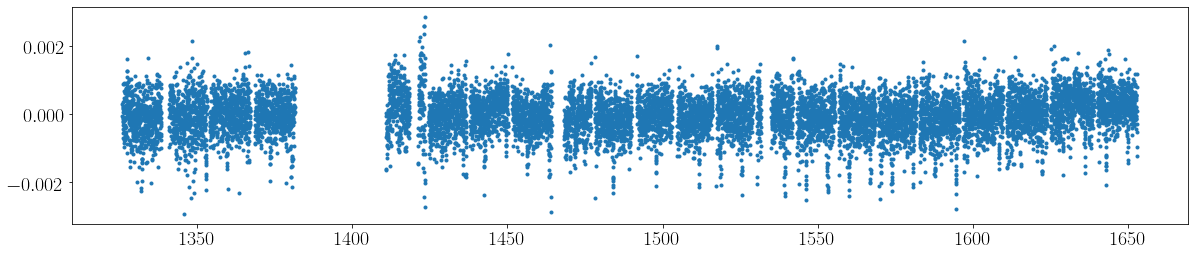

In [42]:
plt.figure(figsize=(20, 4))
plt.plot(df.TIME, df.FLUX, ".")

Remove transits and outliers.

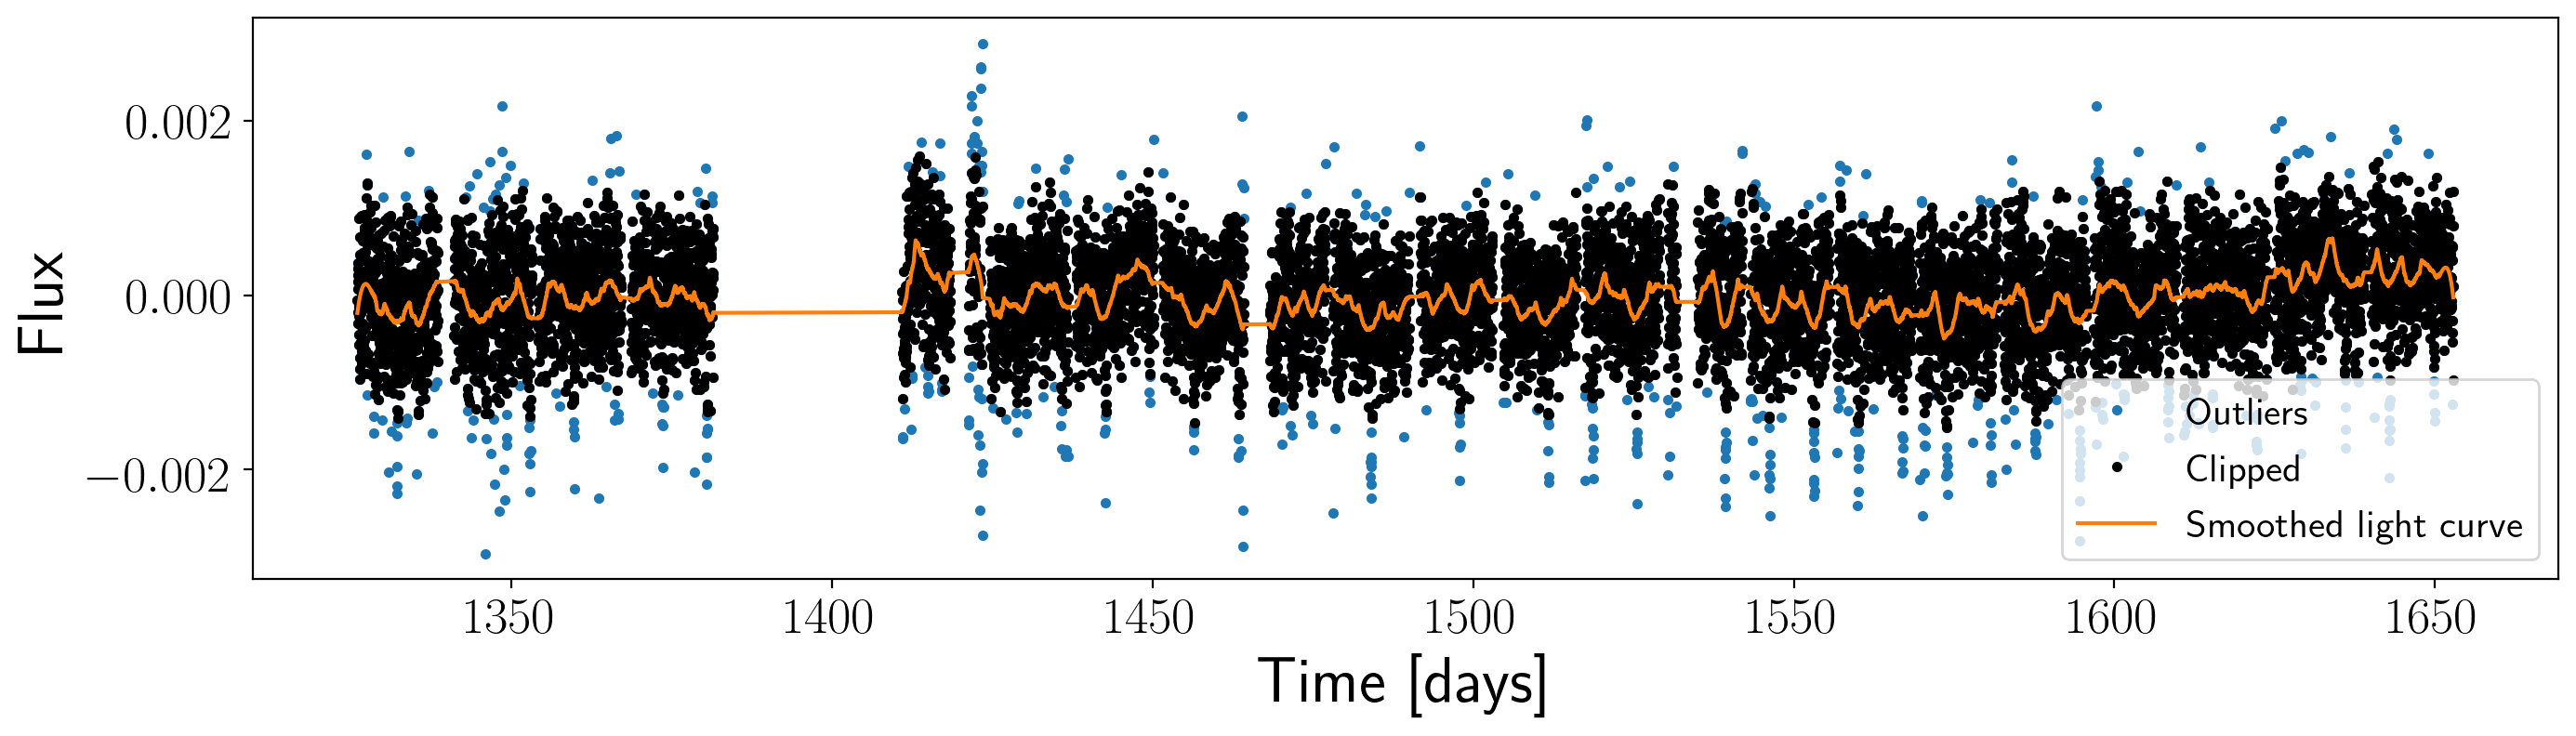

In [50]:
# Then a sigma clip using a Sav-Gol filter for smoothing
mask, smooth = ss.filter_sigma_clip(df.TIME.values, df.FLUX.values, window_length=199, nsigma=2.5)

x, y, yerr = df.TIME.values[mask], df.FLUX.values[mask], df.FLUX_ERR.values[mask]

plt.figure(figsize=(16, 4), dpi=200)
plt.plot(df.TIME, df.FLUX, ".", label="Outliers")
plt.plot(x, y, "k.", label="Clipped")
plt.plot(df.TIME, smooth, label="Smoothed light curve")
plt.xlabel("Time [days]")
plt.ylabel("Flux");
plt.legend(loc="lower right", fontsize=15);

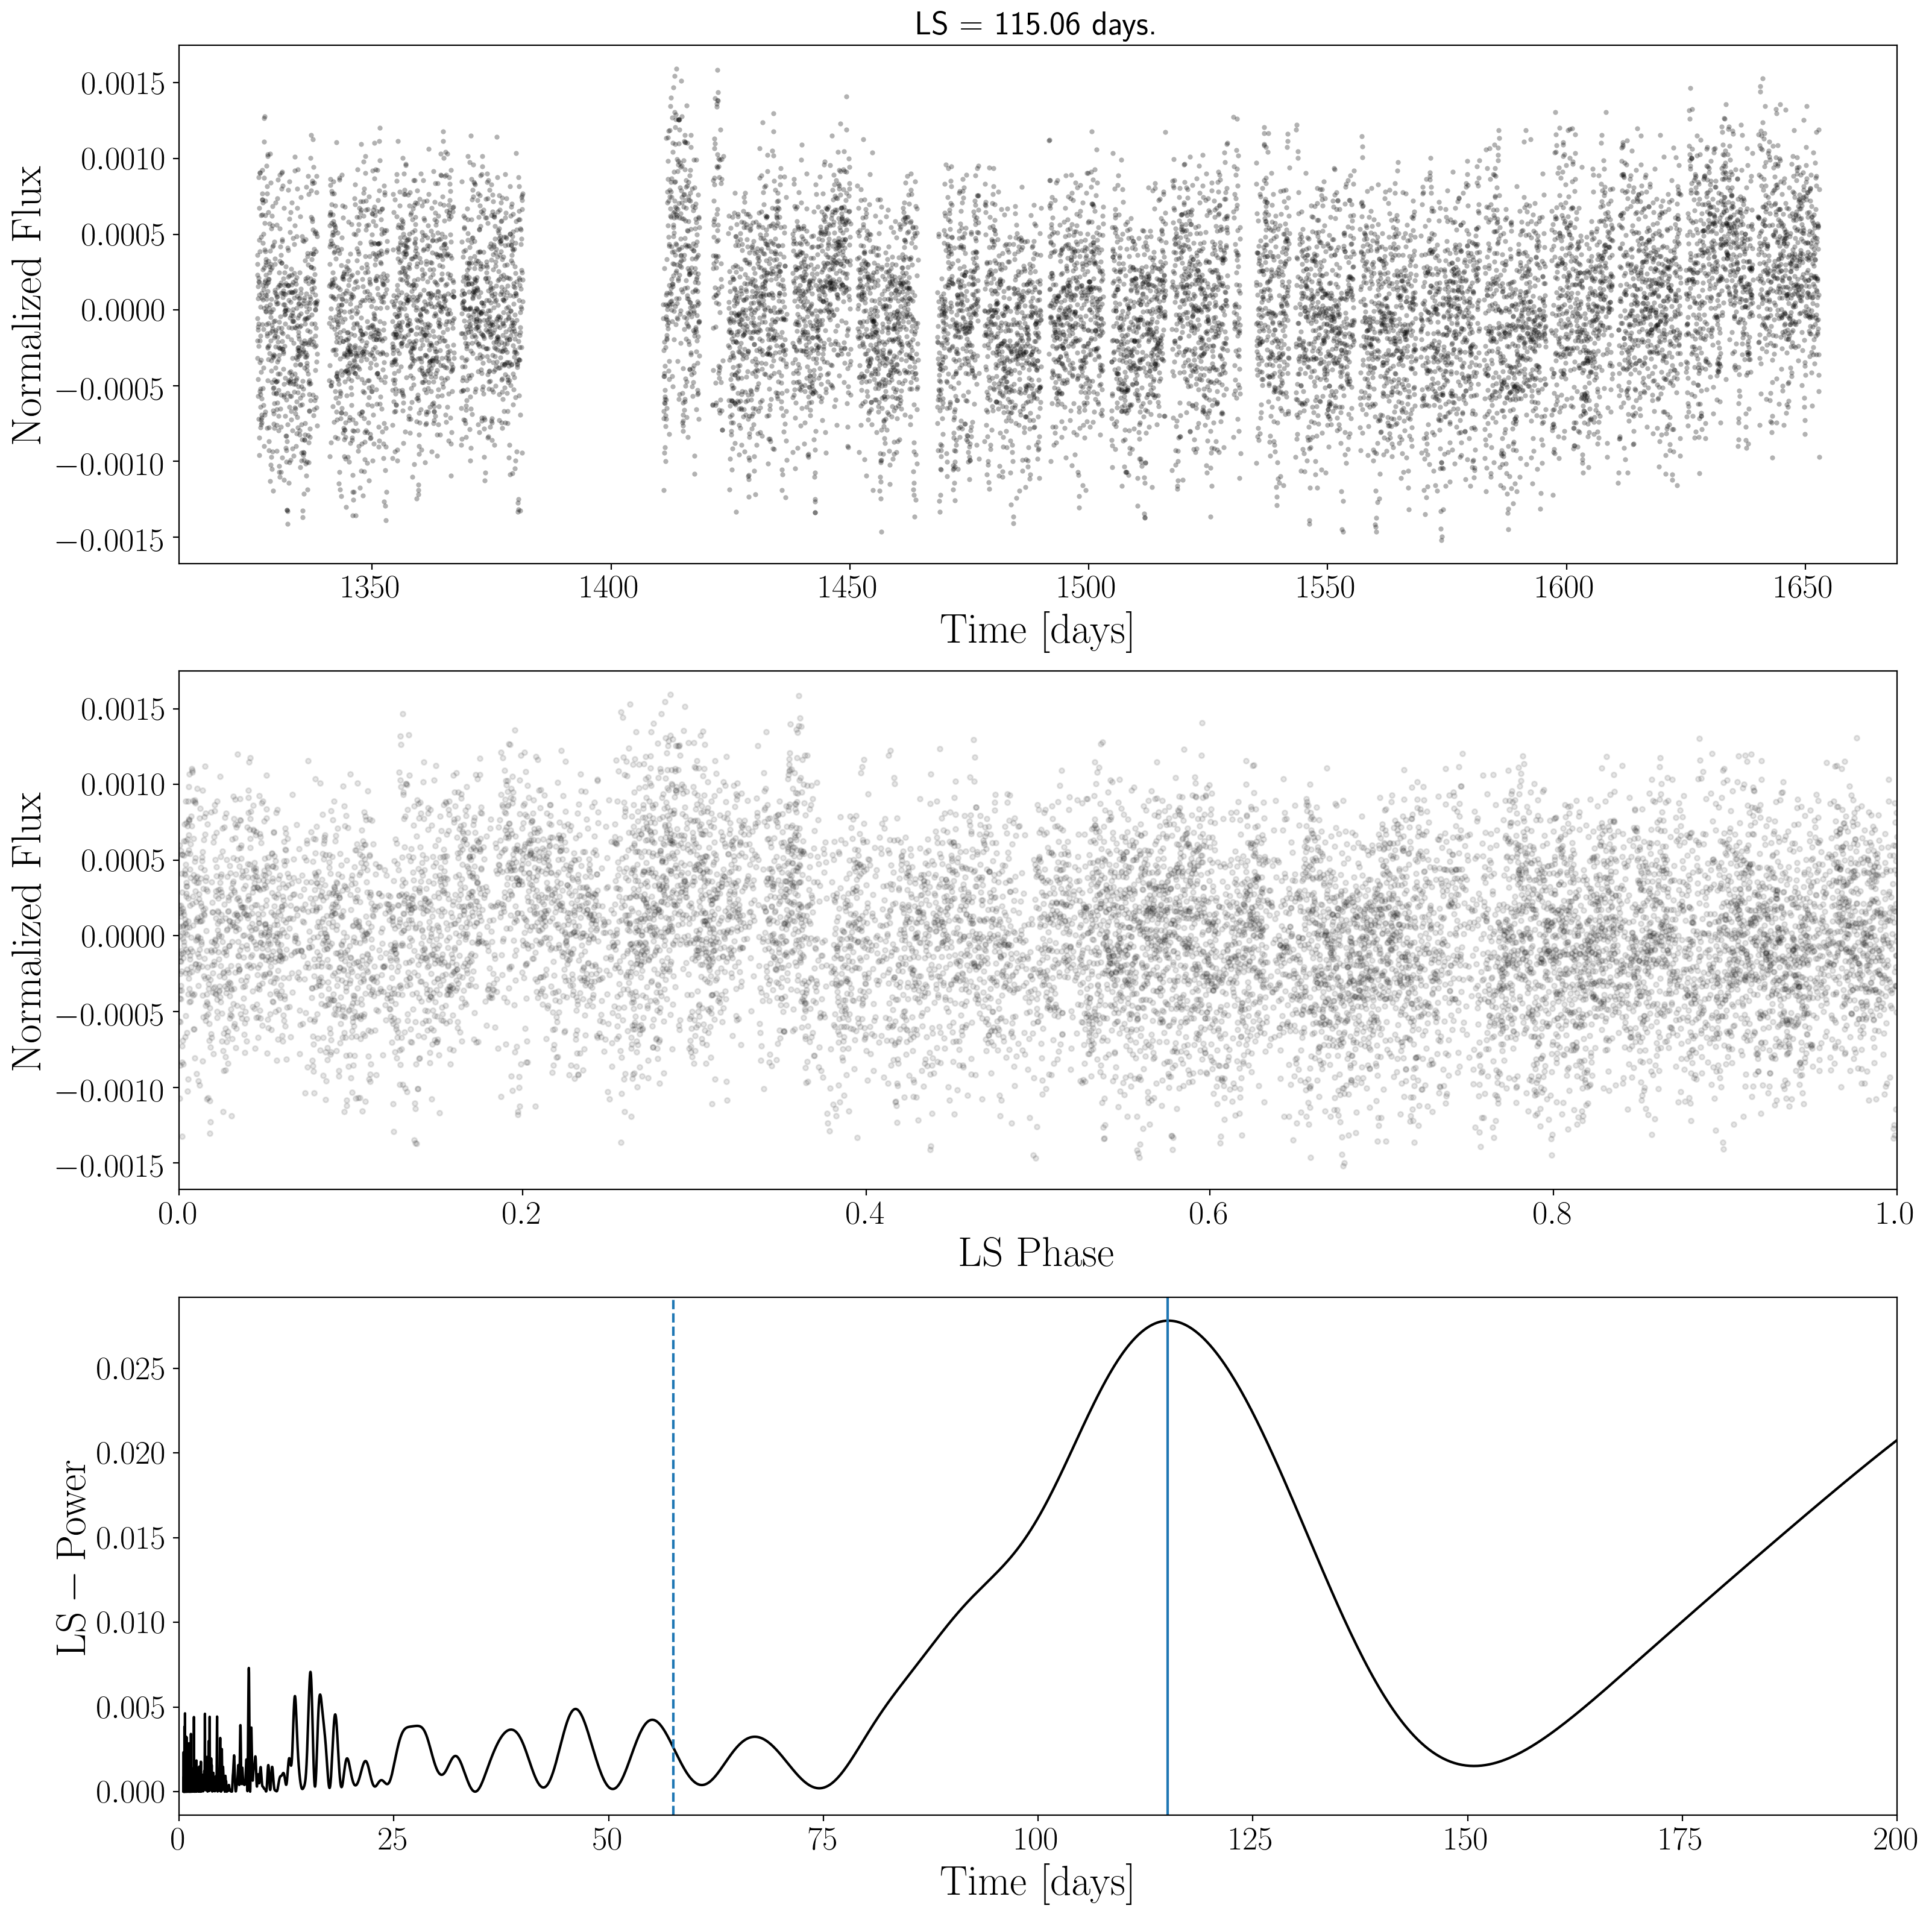

In [56]:
star = ss.RotationModel(x, y, yerr)
ls_period = star.ls_rotation(max_period = 200)
fig = star.big_plot(methods=["ls"], method_xlim=(0, 200))